## Collision Detection using Accelerometer, GPS, and Microphone data from smartphones

##### For analyzing the accelerometer data, we used the datasets (accelerations.csv) and (positions.csv) from (https://zenodo.org/record/820576#.Xr-KJS-z3GI). The columns for accelerations.csv are organized as acceleration_id, trip_id, x_value, y_value, z_value, and timestamp. The columns for positions.csv are organized as pos_id, trip_id, latitude, longitude, altitude, and timestamp.

In [1]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [41]:
# Set G-Force Threshold
g_force_threshold = 4.0

In [42]:
# Read csv datasets
acc = pd.read_csv('accelerations.csv', index_col=0)
pos = pd.read_csv('positions.csv', index_col=0)

In [43]:
# Returns booloean value along with trip id if a collision is detected
def detectCollisionByTripId(tripID):
    trip = acc.copy()
    trip = acc[acc['trip_id'] == tripID]
#   calculate g-force using accelerometer data  
    trip['g_force'] = np.sqrt(trip['x_value']**2+trip['y_value']**2+trip['z_value']**2)
    max_g_force = max(trip['g_force'])
    potential_collision = trip[trip['g_force'] == max_g_force]
    pc_tripID = potential_collision['trip_id'].values[0]
    pc_timestamp = potential_collision['timestamp'].values[0]
    pc_gforce = potential_collision['g_force'].values[0]
    is_collision = pc_gforce >= g_force_threshold
    return is_collision, pc_tripID

In [61]:
detectCollisionByTripId(23)

(True, 23)

In [44]:
def getCollisionLatLongByTripID(pc_tripID):
    loc = pos[pos['trip_id'] == pc_tripID][-1:]
    lat = loc['latitude'].values[0]
    long = loc['longitude'].values[0]
    return lat, long

In [62]:
getCollisionLatLongByTripID(23)

(4703.5341, 1527.7535)

## Machine Learning Model for collision sound detection

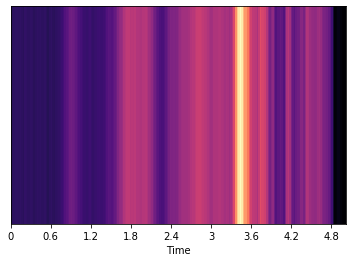

In [2]:
#Displaying the sample MFCC for a audio input
audio, sample_rate = librosa.load("C:/Users/Achuth/Desktop/iot project/CarCrashdataset/Audio-1.mp3", res_type='kaiser_fast')
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=1)
librosa.display.specshow(mfccs, x_axis='time')

In [3]:
#Reading all the audio files in a loop and creating the MFCC's with 10 features

def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=10)
    #librosa.display.specshow(mfccs, x_axis='time')
    mfccsscaled = np.mean(mfccs.T,axis=0)
    return mfccsscaled


# Set the path to the CarCrashdataset 
fulldatasetpath = "C:/Users/Achuth/Desktop/iot project"

metadata = pd.read_csv(fulldatasetpath + "/metadata.csv")

features = []

# Iterate through each sound file and extract the MFCC features 
for index, row in metadata.iterrows():
    file_name = os.path.join((fulldatasetpath)+'/',str(row["fold"])+'/',str(row["slice_file_name"]+'.mp3'))
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')
print(featuresdf)


Finished feature extraction from  1000  files
                                               feature    class_label
0    [-246.45442, 155.92108, -12.987366, 4.842762, ...      car_crash
1    [-246.45442, 155.92108, -12.987366, 4.842762, ...      car_crash
2    [-177.33585, 122.195786, -25.944908, 32.7656, ...      car_crash
3    [-177.33585, 122.195786, -25.944908, 32.7656, ...      car_crash
4    [-300.929, 139.43114, 22.67501, 38.990883, 16....      car_crash
..                                                 ...            ...
995  [-191.07962, 134.24522, -54.28788, -1.3149573,...  not_car_crash
996  [-191.07962, 134.24522, -54.28788, -1.3149573,...  not_car_crash
997  [-191.07962, 134.24522, -54.28788, -1.3149573,...  not_car_crash
998  [-191.07962, 134.24522, -54.28788, -1.3149573,...  not_car_crash
999  [-191.07962, 134.24522, -54.28788, -1.3149573,...  not_car_crash

[1000 rows x 2 columns]


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
yy= LabelEncoder().fit_transform(y)

# split the dataset into train and test dataset's
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.05, random_state = 42)

In [5]:
print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(950, 10) (50, 10) (950,) (50,)


In [6]:
# Building the Machine Learning Model
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[0] 
filter_size = 2

# Construct a TensorFlow-Keras sequential model 

model = Sequential()
model.add(Dense(12, input_dim=10, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [7]:
# Compiling the Machine Learning Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Display Model summary 
model.summary()

# Calculate pre-training accuracy of the test dataset
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 0s 1ms/step
Pre-training accuracy: 18.0000%


In [9]:
# Training the Model with the train dataset and epochs=30
model.fit(x_train, y_train, epochs=30, batch_size=10)

Epoch 1/30
950/950 [==============================] - 0s 223us/step - loss: 4.5485 - accuracy: 0.6779
Epoch 2/30
950/950 [==============================] - 0s 97us/step - loss: 1.0983 - accuracy: 0.8221
Epoch 3/30
950/950 [==============================] - 0s 94us/step - loss: 0.6927 - accuracy: 0.8463
Epoch 4/30
950/950 [==============================] - 0s 88us/step - loss: 0.4343 - accuracy: 0.8832
Epoch 5/30
950/950 [==============================] - 0s 86us/step - loss: 0.3460 - accuracy: 0.9000
Epoch 6/30
950/950 [==============================] - 0s 88us/step - loss: 0.3057 - accuracy: 0.8989
Epoch 7/30
950/950 [==============================] - 0s 89us/step - loss: 0.2751 - accuracy: 0.9200
Epoch 8/30
950/950 [==============================] - 0s 87us/step - loss: 0.2867 - accuracy: 0.9074
Epoch 9/30
950/950 [==============================] - 0s 87us/step - loss: 0.2556 - accuracy: 0.9200
Epoch 10/30
950/950 [==============================] - 0s 91us/step - loss: 0.2389 - accur

In [10]:
# Calculating the Post-Training accuracies for the datasets
score = model.evaluate(x_train, y_train)
print("Training Accuracy: ", 100*score[1])

score = model.evaluate(x_test, y_test)
print("Testing Accuracy: ", 100*score[1])

950/950 [==============================] - 0s 16us/step
Training Accuracy:  95.26315927505493
50/50 [==============================] - 0s 20us/step
Testing Accuracy:  92.00000166893005


In [12]:
#Making the predictions over the test dataset x_test
predictions = model.predict_classes(x_test)

In [13]:
#Setting the path for the experimental dataset
fulldatasetpath = "C:/Users/Achuth/Desktop/iot project"
metadata = pd.read_csv(fulldatasetpath + "/experimetal_data.csv")

# Iterate through each sound file and extract the features
features = []
for index, row in metadata.iterrows():
    file_name = os.path.join((fulldatasetpath)+'/',str(row["fold"])+'/',str(row["slice_file_name"]+'.mp3'))
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(featuresdf), 'test files')

Finished feature extraction from  30 test files


In [14]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
yy= LabelEncoder().fit_transform(y)

In [15]:
predictions = model.predict_classes(X)

In [16]:
preds_conversion = []
for i in predictions:
    converted_label = 'car_crash'
    if (i != 0):
        converted_label = 'not_car_crash'
    preds_conversion.append(converted_label)

preds_conversion
featuresdf['Predictions'] = preds_conversion
featuresdf

,feature,class_label,Predictions
0,"[-246.45442, 155.92108, -12.987366, 4.842762, ...",car_crash,car_crash
1,"[-246.45442, 155.92108, -12.987366, 4.842762, ...",car_crash,car_crash
2,"[-209.83623, 122.65362, -10.790116, 36.17281, ...",car_crash,car_crash
3,"[-212.44893, 108.82279, -12.059541, 36.884037,...",car_crash,car_crash
4,"[-209.83623, 122.65362, -10.790116, 36.17281, ...",car_crash,car_crash
5,"[-212.44893, 108.82279, -12.059541, 36.884037,...",car_crash,car_crash
6,"[-209.83623, 122.65362, -10.790116, 36.17281, ...",car_crash,car_crash
7,"[-212.44893, 108.82279, -12.059541, 36.884037,...",car_crash,car_crash
8,"[-209.83623, 122.65362, -10.790116, 36.17281, ...",car_crash,car_crash
9,"[-212.44893, 108.82279, -12.059541, 36.884037,...",car_crash,car_crash


In [17]:
def getAccuracy():
    count = 0
    for label, row in featuresdf.iterrows():
        if row.Predictions == row.class_label:
            count += 1
    return (count/len(featuresdf))*100
        
getAccuracy()

93.33333333333333

In [33]:
def is_collision_sound(audio_file):
    features = []
    file_name = "C:/Users/Achuth/Desktop/iot project/CarCrashdataset/"+audio_file
    class_label = row["class_name"]
    data = extract_features(file_name)
    features.append([data, class_label])
    
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
    
    X = np.array(featuresdf.feature.tolist())
    y = np.array(featuresdf.class_label.tolist())
    yy= LabelEncoder().fit_transform(y)
    predictions = model.predict_classes(X)
    if(predictions == 0):
        return 'Yes'
    else:
        return 'No'    

## Collision Detection

##### We detect a collision based on two parameters: g-force and crash sound. To calculate the g-force we will utilize the accelerometer data received from the smartphone sensors. If the g-force exceeds a value of 4, we will procced to analyze the second parameter, the crash sound. We employ a Machine Learning model in tandem with a neural network to differentiate between a crash and a non-crash sound. If both the parameters return true, we then say that a collision has occurred and share the co-ordinates of the crash location.


##### Note: trip_id ranges from 3 - 35, out of which id's 12 and 23 have g-force > 4. Audio files range from Audio-1 - Audio-1000 out of which Audio 1 - Audio 900 represent crash sounds and the rest represent non-crash sounds. 


In [53]:
# trip_id gives the accelerometer data from the dataset
# audio_file contains the collision sound collected from microphone
def detectCollision(trip_id, audio_file):
    is_collision, pc_tripID = detectCollisionByTripId(trip_id)
    if is_collision:
        is_crash_sound = is_collision_sound(audio_file)
        if is_crash_sound == 'Yes':
            lat, long = getCollisionLatLongByTripID(pc_tripID)
            print('Collision detected!')
            print('Location')
            print('Latitude: '+ str(lat))
            print('Longitude: '+ str(long))
            print('Notified emergency responders!')
        else:
            print('Not a crash! False positive from accelerometer.')
    else:
        print('Not a crash!')

##### Case 1: Collision

In [57]:
detectCollision(23, 'Audio-233.mp3')

Collision detected!
Location
Latitude: 4703.5341
Longitude: 1527.7535
Notified emergency responders!


##### Case 2: Accelerometer False-positive

In [59]:
detectCollision(23, 'Audio-956.mp3')

Not a crash! False positive from accelerometer.


##### Case 3: G-force < threshold

In [60]:
detectCollision(3, 'Audio-1.mp3')

Not a crash!
